이 자료는 위키독스 딥 러닝을 이용한 자연어 처리 입문의 BiLSTM + CRF + 문자 임베딩의 튜토리얼 자료입니다.

링크 : https://wikidocs.net/147219  
링크 : https://wikidocs.net/147234  
링크 : https://wikidocs.net/147299

이 자료는 2021년 12월 27일에 마지막으로 테스트되었습니다.

In [ ]:
import tensorflow as tf
tf.__version__

'2.7.0'

# CRF layer 설치

In [ ]:
!pip install keras-crf==0.3.0

     |████████████████████████████████| 1.1 MB 5.5 MB/s 


In [ ]:
# 모델 평가
!pip install seqeval

     |████████████████████████████████| 43 kB 828 kB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=487266b3ca3a8ba64c2e4741beffd6bbf3a7f3836117a70c4fa7f4ce54510c12
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
!pip list | grep keras-crf

keras-crf                     0.3.0


ner_dataset.csv를 Colab에 업로드하세요.

# 데이터 전처리

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")

In [ ]:
data[:5]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
print('데이터프레임 행의 개수 : {}'.format(len(data)))

데이터프레임 행의 개수 : 1048575


In [ ]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : True


In [ ]:
print('어떤 열에 Null값이 있는지 출력')
print('==============================')
data.isnull().sum()

어떤 열에 Null값이 있는지 출력


Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [ ]:
print('sentence # 열의 중복을 제거한 값의 개수 : {}'.format(data['Sentence #'].nunique()))
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))
print('Tag 열의 중복을 제거한 값의 개수 : {}'.format(data.Tag.nunique()))

sentence # 열의 중복을 제거한 값의 개수 : 47959
Word 열의 중복을 제거한 값의 개수 : 35178
Tag 열의 중복을 제거한 값의 개수 : 17


In [ ]:
print('Tag 열의 각각의 값의 개수 카운트')
print('================================')
print(data.groupby('Tag').size().reset_index(name='count'))

Tag 열의 각각의 값의 개수 카운트
      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


In [ ]:
data = data.fillna(method="ffill")

In [ ]:
print(data.tail())

              Sentence #       Word  POS Tag
1048570  Sentence: 47959       they  PRP   O
1048571  Sentence: 47959  responded  VBD   O
1048572  Sentence: 47959         to   TO   O
1048573  Sentence: 47959        the   DT   O
1048574  Sentence: 47959     attack   NN   O


In [ ]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : False


In [ ]:
data['Word'] = data['Word'].str.lower()
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))

Word 열의 중복을 제거한 값의 개수 : 31817


In [ ]:
print(data[:5])

    Sentence #           Word  POS Tag
0  Sentence: 1      thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O


In [ ]:
func = lambda temp: [(w, t) for w, t in zip(temp["Word"].values.tolist(), temp["Tag"].values.tolist())]
tagged_sentences=[t for t in data.groupby("Sentence #").apply(func)]
print("전체 샘플 개수: {}".format(len(tagged_sentences)))

전체 샘플 개수: 47959


In [ ]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [ ]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 47,959개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

In [ ]:
print(sentences[0])
print(ner_tags[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [ ]:
print(sentences[98])
print(ner_tags[98])

['she', 'had', 'once', 'received', 'a', 'kidney', 'transplant', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


샘플의 최대 길이 : 104
샘플의 평균 길이 : 21.863988


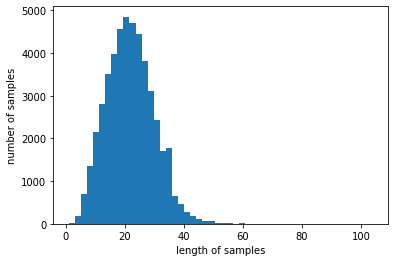

In [ ]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
src_tokenizer = Tokenizer(oov_token='OOV') # 모든 단어를 사용하지만 인덱스 1에는 단어 'OOV'를 할당한다.
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer(lower=False) # 태깅 정보들은 내부적으로 대문자를 유지한채로 저장
tar_tokenizer.fit_on_texts(ner_tags)

In [ ]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 31819
개체명 태깅 정보 집합의 크기 : 18


In [ ]:
print('단어 OOV의 인덱스 : {}'.format(src_tokenizer.word_index['OOV']))

단어 OOV의 인덱스 : 1


In [ ]:
X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

In [ ]:
print(X_data[0])
print(y_data[0])

[254, 6, 967, 16, 1795, 238, 468, 7, 523, 2, 129, 5, 61, 9, 571, 2, 833, 6, 186, 90, 22, 15, 56, 3]
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1]


In [ ]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

In [ ]:
print(index_to_ner)

{1: 'O', 2: 'B-geo', 3: 'B-tim', 4: 'B-org', 5: 'I-per', 6: 'B-per', 7: 'I-org', 8: 'B-gpe', 9: 'I-geo', 10: 'I-tim', 11: 'B-art', 12: 'B-eve', 13: 'I-art', 14: 'I-eve', 15: 'B-nat', 16: 'I-gpe', 17: 'I-nat', 0: 'PAD'}


In [ ]:
decoded = []
for index in X_data[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존의 문장 : {}'.format(sentences[0]))
print('디코딩 문장 : {}'.format(decoded))

기존의 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
디코딩 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


In [ ]:
max_len = 70
X_data = pad_sequences(X_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)

In [ ]:
print(X_data.shape)
print(y_data.shape)

(47959, 70)
(47959, 70)


In [ ]:
X_train, X_test, y_train_int, y_test_int = train_test_split(X_data, y_data, test_size=.2, random_state=777)

In [ ]:
y_train = to_categorical(y_train_int, num_classes=tag_size)
y_test = to_categorical(y_test_int, num_classes=tag_size)

In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_train_int.shape))
print('훈련 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_test_int.shape))
print('테스트 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블(정수 인코딩)의 크기 : (38367, 70)
훈련 샘플 레이블(원-핫 인코딩)의 크기 : (38367, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블(정수 인코딩)의 크기 : (9592, 70)
테스트 샘플 레이블(원-핫 인코딩)의 크기 : (9592, 70, 18)


# char 정보를 사용하기 위한 추가 전처리

In [ ]:
# char_vocab 만들기
words = list(set(data["Word"].values))
chars = set([w_i for w in words for w_i in w])
chars = sorted(list(chars))
print(chars)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', '\x85', '\x91', '\x92', '\x93', '\x94', '\x96', '\x97', '\xa0', '°', 'é', 'ë', 'ö', 'ü']


In [ ]:
char_to_index = {c: i + 2 for i, c in enumerate(chars)}
char_to_index["OOV"] = 1
char_to_index["PAD"] = 0

In [ ]:
index_to_char = {}
for key, value in char_to_index.items():
    index_to_char[value] = key

In [ ]:
print(sentences[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


In [ ]:
max_len_char = 15

def padding_char_indice(char_indice, max_len_char):
  return pad_sequences(
        char_indice, maxlen=max_len_char, padding='post', value = 0)

def integer_coding(sentences):
  char_data = []
  for ts in sentences:
    word_indice = [word_to_index[t] for t in ts]
    char_indice = [[char_to_index[char] for char in t]  
                                          for t in ts]
    char_indice = padding_char_indice(char_indice, max_len_char)

    for chars_of_token in char_indice:
      if len(chars_of_token) > max_len_char:
        continue
    char_data.append(char_indice)
  return char_data

In [ ]:
X_char_data = integer_coding(sentences)

In [ ]:
# 정수 인코딩 이전의 기존 문장
print(sentences[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


In [ ]:
print(X_data[0])

[ 254    6  967   16 1795  238  468    7  523    2  129    5   61    9
  571    2  833    6  186   90   22   15   56    3    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [ ]:
print(X_char_data[0])

[[53 41 48 54 52 34 47 37 52  0  0  0  0  0  0]
 [48 39  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [37 38 46 48 47 52 53 51 34 53 48 51 52  0  0]
 [41 34 55 38  0  0  0  0  0  0  0  0  0  0  0]
 [46 34 51 36 41 38 37  0  0  0  0  0  0  0  0]
 [53 41 51 48 54 40 41  0  0  0  0  0  0  0  0]
 [45 48 47 37 48 47  0  0  0  0  0  0  0  0  0]
 [53 48  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [49 51 48 53 38 52 53  0  0  0  0  0  0  0  0]
 [53 41 38  0  0  0  0  0  0  0  0  0  0  0  0]
 [56 34 51  0  0  0  0  0  0  0  0  0  0  0  0]
 [42 47  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [42 51 34 50  0  0  0  0  0  0  0  0  0  0  0]
 [34 47 37  0  0  0  0  0  0  0  0  0  0  0  0]
 [37 38 46 34 47 37  0  0  0  0  0  0  0  0  0]
 [53 41 38  0  0  0  0  0  0  0  0  0  0  0  0]
 [56 42 53 41 37 51 34 56 34 45  0  0  0  0  0]
 [48 39  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [35 51 42 53 42 52 41  0  0  0  0  0  0  0  0]
 [53 51 48 48 49 52  0  0  0  0  0  0  0  0  0]
 [39 51 48 46  0  0  0  0  0  0  0  0  0

In [ ]:
X_char_data = pad_sequences(X_char_data, maxlen=max_len, padding='post', value = 0)

In [ ]:
X_char_train, X_char_test, _, _ = train_test_split(X_char_data, y_data, test_size=.2, random_state=777)

In [ ]:
X_char_train = np.array(X_char_train)
X_char_test = np.array(X_char_test)

In [ ]:
print(X_train[0])

[ 150  928  361   17 2624    9 4131 3567    9    8 2893 1250  880  107
    3    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [ ]:
print(index_to_word[150])

soldiers


In [ ]:
print(X_char_train[0])

[[52 48 45 ...  0  0  0]
 [51 38 53 ...  0  0  0]
 [39 42 51 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [ ]:
print(X_char_train[0][0])

[52 48 45 37 42 38 51 52  0  0  0  0  0  0  0]


In [ ]:
print(' '.join([index_to_char[index] for index in X_char_train[0][0]]))

s o l d i e r s PAD PAD PAD PAD PAD PAD PAD


In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('훈련 샘플 char 데이터의 크기 : {}'.format(X_char_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블의 크기 : (38367, 70, 18)
훈련 샘플 char 데이터의 크기 : (38367, 70, 15)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블의 크기 : (9592, 70, 18)


# BiLSTM을 이용한 개체명 인식

## 모델링

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

In [ ]:
embedding_dim = 128
hidden_units = 256

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         4072832   
                                                                 
 bidirectional (Bidirectiona  (None, None, 512)        788480    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, None, 18)         9234      
 ibuted)                                                         
                                                                 
Total params: 4,870,546
Trainable params: 4,870,546
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, validation_split=0.1)

Epoch 1/6
270/270 [==============================] - 20s 38ms/step - loss: 0.1768 - accuracy: 0.8739 - val_loss: 0.0820 - val_accuracy: 0.9291
Epoch 2/6
270/270 [==============================] - 7s 24ms/step - loss: 0.0558 - accuracy: 0.9491 - val_loss: 0.0489 - val_accuracy: 0.9534
Epoch 3/6
270/270 [==============================] - 6s 21ms/step - loss: 0.0375 - accuracy: 0.9642 - val_loss: 0.0443 - val_accuracy: 0.9572
Epoch 4/6
270/270 [==============================] - 6s 21ms/step - loss: 0.0304 - accuracy: 0.9699 - val_loss: 0.0427 - val_accuracy: 0.9585
Epoch 5/6
270/270 [==============================] - 6s 21ms/step - loss: 0.0260 - accuracy: 0.9737 - val_loss: 0.0434 - val_accuracy: 0.9587
Epoch 6/6
270/270 [==============================] - 6s 21ms/step - loss: 0.0228 - accuracy: 0.9765 - val_loss: 0.0444 - val_accuracy: 0.9587


In [ ]:
model.save('bilstm.h5')

In [ ]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], true, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


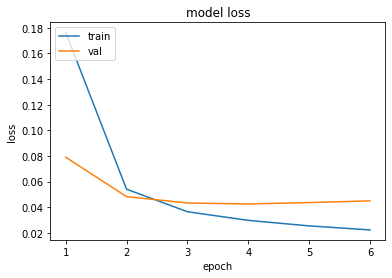

In [ ]:
epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from seqeval.metrics import f1_score, classification_report

In [ ]:
def sequences_to_tag(sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
    result = []
    for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
        temp = []
        for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
            pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            temp.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
        result.append(temp)
    return result

In [ ]:
y_predicted = model.predict([X_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

In [ ]:
print(classification_report(test_tags, pred_tags))

              precision    recall  f1-score   support

         art       0.16      0.05      0.07        63
         eve       0.38      0.27      0.31        52
         geo       0.81      0.85      0.83      7620
         gpe       0.95      0.94      0.95      3145
         nat       0.45      0.24      0.32        37
         org       0.62      0.55      0.58      4033
         per       0.72      0.71      0.72      3545
         tim       0.87      0.83      0.85      4067

   micro avg       0.80      0.78      0.79     22562
   macro avg       0.62      0.55      0.58     22562
weighted avg       0.79      0.78      0.78     22562



## 성능

In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 78.7%


# BiLSTM-CRF를 이용한 개체명인식

## 모델링

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional, TimeDistributed, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_crf import CRFModel
from seqeval.metrics import f1_score, classification_report

In [ ]:
embedding_dim = 128
hidden_units = 64
dropout_ratio = 0.3

sequence_input = Input(shape=(max_len,),dtype=tf.int32, name='sequence_input')

model_embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_len)(sequence_input)

model_bilstm = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(model_embedding)

model_dropout = TimeDistributed(Dropout(dropout_ratio))(model_bilstm)

model_dense = TimeDistributed(Dense(tag_size, activation='relu'))(model_dropout)

base = Model(inputs=sequence_input, outputs=model_dense)
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')
model.summary()

Model: "crf_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence_input (InputLayer)    [(None, 70)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 70, 128)      4072832     ['sequence_input[0][0]']         
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 70, 128)     98816       ['embedding_2[0][0]']            
 )                                                                                                
                                                                                                  
 time_distributed_3 (TimeDistri  (None, 70, 128)     0           ['bidirectional_2[0][0]']

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_crf/cp.ckpt', monitor='val_decode_sequence_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

In [ ]:
history = model.fit(X_train, y_train_int, batch_size=128, epochs=15, validation_split=0.1, callbacks=[mc, es])

Epoch 1/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9204 - loss: 28.7448
Epoch 00001: val_decode_sequence_accuracy improved from -inf to 0.96133, saving model to bilstm_crf/cp.ckpt
270/270 [==============================] - 46s 147ms/step - decode_sequence_accuracy: 0.9204 - loss: 28.6784 - val_decode_sequence_accuracy: 0.9613 - val_loss: 10.0355
Epoch 2/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9702 - loss: 6.8184
Epoch 00002: val_decode_sequence_accuracy improved from 0.96133 to 0.97886, saving model to bilstm_crf/cp.ckpt
270/270 [==============================] - 39s 146ms/step - decode_sequence_accuracy: 0.9702 - loss: 6.8108 - val_decode_sequence_accuracy: 0.9789 - val_loss: 5.2493
Epoch 3/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9817 - loss: 3.9034
Epoch 00003: val_decode_sequence_accuracy improved from 0.97886 to 0.98280, saving model to bilstm_crf/cp.ckpt

In [ ]:
model.load_weights('bilstm_crf/cp.ckpt')

In [ ]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]]))[0] # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], true, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


In [ ]:
y_predicted = model.predict(X_test)[0]

In [ ]:
def sequences_to_tag(sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
    result = []
    for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
        temp = []
        for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
            pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            temp.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
        result.append(temp)
    return result

In [ ]:
def sequences_to_tag_for_crf(sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
    result = []
    for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
        temp = []
        for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
            # pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            pred_index = pred
            temp.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
        result.append(temp)
    return result

In [ ]:
pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

In [ ]:
print(classification_report(test_tags, pred_tags))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.90      0.17      0.29        52
         geo       0.83      0.84      0.84      7620
         gpe       0.95      0.93      0.94      3145
         nat       0.00      0.00      0.00        37
         org       0.64      0.58      0.61      4033
         per       0.76      0.70      0.73      3545
         tim       0.86      0.83      0.85      4067

   micro avg       0.81      0.78      0.80     22562
   macro avg       0.62      0.51      0.53     22562
weighted avg       0.81      0.78      0.79     22562



## 성능

In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 79.6%


# BiLSTM-CNN을 이용한 개체명인식

## 모델링

In [ ]:
from tensorflow.keras.layers import Embedding, Input, TimeDistributed, Dropout, concatenate, Bidirectional, LSTM, Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras import Model
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from seqeval.metrics import f1_score, classification_report

In [ ]:
embedding_dim = 128
char_embedding_dim = 64
dropout_ratio = 0.5
hidden_units = 256
num_filters = 30
kernel_size = 3

# 단어 임베딩
words_input = Input(shape=(None,),dtype='int32',name='words_input')
words = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(words_input)

# char 임베딩
character_input = Input(shape=(None, max_len_char,),name='char_input')
embed_char_out = TimeDistributed(Embedding(len(char_to_index), char_embedding_dim, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(character_input)
dropout = Dropout(dropout_ratio)(embed_char_out)

# char 임베딩에 대해서는 Conv1D 수행
conv1d_out= TimeDistributed(Conv1D(kernel_size=kernel_size, filters=num_filters, padding='same', activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(max_len_char))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(dropout_ratio)(char)

# char 임베딩을 Conv1D 수행한 뒤에 단어 임베딩과 연결
output = concatenate([words, char])

# 연결한 벡터를 가지고 문장의 길이만큼 LSTM을 수행
output = Bidirectional(LSTM(hidden_units, return_sequences=True, dropout=dropout_ratio))(output)

# 출력층
output = TimeDistributed(Dense(tag_size, activation='softmax'))(output)

model = Model(inputs=[words_input, character_input], outputs=[output])
model.compile(loss='categorical_crossentropy', optimizer='nadam',  metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, None, 15)]   0           []                               
                                                                                                  
 char_embedding (TimeDistribute  (None, None, 15, 64  4736       ['char_input[0][0]']             
 d)                             )                                                                 
                                                                                                  
 dropout_2 (Dropout)            (None, None, 15, 64  0           ['char_embedding[0][0]']         
                                )                                                                 
                                                                                            

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_cnn.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
history = model.fit([X_train, X_char_train], y_train, batch_size=128, epochs=15, validation_split=0.1, verbose=1, callbacks=[es, mc])

Epoch 1/15
270/270 [==============================] - ETA: 0s - loss: 0.2072 - acc: 0.9474
Epoch 00001: val_acc improved from -inf to 0.97665, saving model to bilstm_cnn.h5
270/270 [==============================] - 23s 47ms/step - loss: 0.2072 - acc: 0.9474 - val_loss: 0.0852 - val_acc: 0.9766
Epoch 2/15
269/270 [============================>.] - ETA: 0s - loss: 0.0635 - acc: 0.9820
Epoch 00002: val_acc improved from 0.97665 to 0.98477, saving model to bilstm_cnn.h5
270/270 [==============================] - 12s 43ms/step - loss: 0.0635 - acc: 0.9820 - val_loss: 0.0521 - val_acc: 0.9848
Epoch 3/15
270/270 [==============================] - ETA: 0s - loss: 0.0453 - acc: 0.9867
Epoch 00003: val_acc improved from 0.98477 to 0.98625, saving model to bilstm_cnn.h5
270/270 [==============================] - 12s 44ms/step - loss: 0.0453 - acc: 0.9867 - val_loss: 0.0454 - val_acc: 0.9862
Epoch 4/15
270/270 [==============================] - ETA: 0s - loss: 0.0381 - acc: 0.9886
Epoch 00004: va

In [ ]:
model = load_model('bilstm_cnn.h5')

In [ ]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.

# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = model.predict([np.array([X_test[i]]), np.array([X_char_test[i]])])
y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], true, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


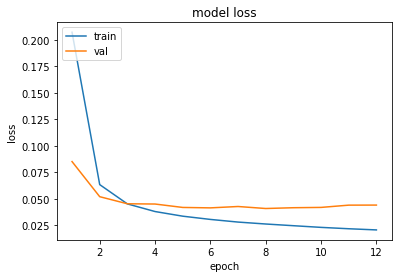

In [ ]:
epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def sequences_to_tag(sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
    result = []
    for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
        temp = []
        for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
            pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            temp.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
        result.append(temp)
    return result

In [ ]:
y_predicted = model.predict([X_test, X_char_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

In [ ]:
print(classification_report(test_tags, pred_tags))

              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.36      0.27      0.31        52
         geo       0.82      0.86      0.84      7620
         gpe       0.96      0.94      0.95      3145
         nat       0.62      0.14      0.22        37
         org       0.61      0.56      0.59      4033
         per       0.73      0.72      0.73      3545
         tim       0.87      0.84      0.86      4067

   micro avg       0.80      0.79      0.79     22562
   macro avg       0.62      0.54      0.56     22562
weighted avg       0.79      0.79      0.79     22562



## 성능

In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 79.3%


#BiLSTM-CNN-CRF를 이용한 개체명인식

## 모델링

In [ ]:
import tensorflow as tf
from keras_crf import CRFModel

In [ ]:
embedding_dim = 128
char_embedding_dim = 64
dropout_ratio = 0.5
hidden_units = 256
num_filters = 30
kernel_size = 3

# 단어 임베딩
words_input = Input(shape=(None,),dtype='int32',name='words_input')
words = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(words_input)

# char 임베딩
character_input = Input(shape=(None, max_len_char,),name='char_input')
embed_char_out = TimeDistributed(Embedding(len(char_to_index), char_embedding_dim, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(character_input)
dropout = Dropout(dropout_ratio)(embed_char_out)

# char 임베딩에 대해서는 Conv1D 수행
conv1d_out= TimeDistributed(Conv1D(kernel_size=kernel_size, filters=num_filters, padding='same',activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(max_len_char))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(dropout_ratio)(char)

# char 임베딩을 Conv1D 수행한 뒤에 단어 임베딩과 연결
output = concatenate([words, char])

# 연결한 벡터를 가지고 문장의 길이만큼 LSTM을 수행
output = Bidirectional(LSTM(hidden_units, return_sequences=True, dropout=dropout_ratio))(output)

# 출력층
output = TimeDistributed(Dense(tag_size, activation='relu'))(output)

base = Model(inputs=[words_input, character_input], outputs=[output])
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')
model.summary()

Model: "crf_model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, None, 15)]   0           []                               
                                                                                                  
 char_embedding (TimeDistribute  (None, None, 15, 64  4736       ['char_input[0][0]']             
 d)                             )                                                                 
                                                                                                  
 dropout_4 (Dropout)            (None, None, 15, 64  0           ['char_embedding[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_cnn_crf/cp.ckpt', monitor='val_decode_sequence_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

In [ ]:
history = model.fit([X_train, X_char_train], y_train_int, batch_size=128, epochs=15, validation_split=0.1, callbacks=[mc, es])

Epoch 1/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9270 - loss: 20.0089
Epoch 00001: val_decode_sequence_accuracy improved from -inf to 0.96776, saving model to bilstm_cnn_crf/cp.ckpt
270/270 [==============================] - 59s 193ms/step - decode_sequence_accuracy: 0.9270 - loss: 19.9610 - val_decode_sequence_accuracy: 0.9678 - val_loss: 7.4661
Epoch 2/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9787 - loss: 5.1367
Epoch 00002: val_decode_sequence_accuracy improved from 0.96776 to 0.98258, saving model to bilstm_cnn_crf/cp.ckpt
270/270 [==============================] - 45s 167ms/step - decode_sequence_accuracy: 0.9787 - loss: 5.1319 - val_decode_sequence_accuracy: 0.9826 - val_loss: 4.0034
Epoch 3/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9856 - loss: 3.1769
Epoch 00003: val_decode_sequence_accuracy improved from 0.98258 to 0.98532, saving model to bilstm_cnn_

In [ ]:
model.load_weights('bilstm_cnn_crf/cp.ckpt')

In [ ]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.

# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = model.predict([np.array([X_test[i]]), np.array([X_char_test[i]])])[0] 
true = np.argmax(y_test[i], -1) # 원-핫 벡터를 정수 인코딩으로 변경.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], true, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


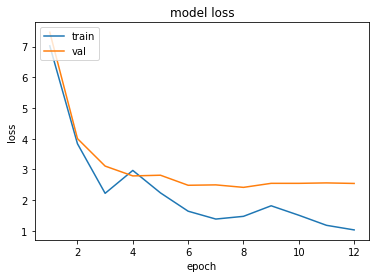

In [ ]:
epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_predicted = model.predict([X_test, X_char_test])[0]
pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

In [ ]:
print(classification_report(test_tags, pred_tags))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.00      0.00      0.00        52
         geo       0.80      0.89      0.84      7620
         gpe       0.94      0.94      0.94      3145
         nat       1.00      0.16      0.28        37
         org       0.68      0.55      0.61      4033
         per       0.79      0.73      0.76      3545
         tim       0.88      0.84      0.86      4067

   micro avg       0.82      0.80      0.81     22562
   macro avg       0.64      0.51      0.54     22562
weighted avg       0.81      0.80      0.80     22562



## 성능

In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 80.6%


# BiLSTM-BiLSTM-CRF을 이용한 개체명 인식

## 모델링

In [ ]:
embedding_dim = 128
char_embedding_dim = 64
dropout_ratio = 0.3
hidden_units = 64

word_ids = Input(batch_shape=(None, None), dtype='int32', name='word_input')
word_embeddings = Embedding(input_dim=vocab_size,
                                        output_dim=embedding_dim,
                                        name='word_embedding')(word_ids)

char_ids = Input(batch_shape=(None, None, None), dtype='int32', name='char_input')
char_embeddings = Embedding(input_dim=(len(char_to_index)),
                                        output_dim=char_embedding_dim,
                                        embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5),
                                        name='char_embedding')(char_ids)

char_embeddings = TimeDistributed(Bidirectional(LSTM(hidden_units)))(char_embeddings)
word_embeddings = concatenate([word_embeddings, char_embeddings])

word_embeddings = Dropout(dropout_ratio)(word_embeddings)
output = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(word_embeddings)
output = TimeDistributed(Dense(tag_size, activation='relu'))(output)

base = Model(inputs=[word_ids, char_ids], outputs=[output])
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')

model.summary()

Model: "crf_model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, None, None)  0           []                               
                                ]                                                                 
                                                                                                  
 word_input (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 char_embedding (Embedding)     (None, None, None,   4736        ['char_input[0][0]']             
                                64)                                                               
                                                                                        

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_bilstm_crf/cp.ckpt', monitor='val_decode_sequence_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

In [ ]:
history = model.fit([X_train, X_char_train], y_train_int, batch_size=128, epochs=15, validation_split=0.1, callbacks=[mc, es])

Epoch 1/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9263 - loss: 22.6385
Epoch 00001: val_decode_sequence_accuracy improved from -inf to 0.97024, saving model to bilstm_bilstm_crf/cp.ckpt
270/270 [==============================] - 62s 195ms/step - decode_sequence_accuracy: 0.9263 - loss: 22.5786 - val_decode_sequence_accuracy: 0.9702 - val_loss: 7.3148
Epoch 2/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9787 - loss: 4.9090
Epoch 00002: val_decode_sequence_accuracy improved from 0.97024 to 0.98270, saving model to bilstm_bilstm_crf/cp.ckpt
270/270 [==============================] - 47s 173ms/step - decode_sequence_accuracy: 0.9787 - loss: 4.9062 - val_decode_sequence_accuracy: 0.9827 - val_loss: 3.7907
Epoch 3/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9852 - loss: 3.0332
Epoch 00003: val_decode_sequence_accuracy improved from 0.98270 to 0.98497, saving model to bilst

In [ ]:
model.load_weights('bilstm_bilstm_crf/cp.ckpt')

In [ ]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.

# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = model.predict([np.array([X_test[i]]), np.array([X_char_test[i]])])[0]
true = np.argmax(y_test[i], -1) # 원-핫 벡터를 정수 인코딩으로 변경.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], true, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


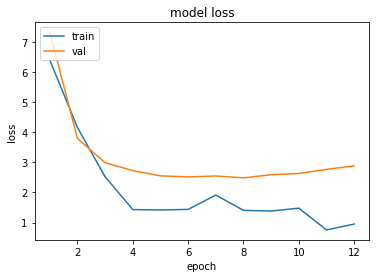

In [ ]:
epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_predicted = model.predict([X_test, X_char_test])[0]
pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

In [ ]:
print(classification_report(test_tags, pred_tags))

              precision    recall  f1-score   support

         art       0.44      0.06      0.11        63
         eve       0.70      0.27      0.39        52
         geo       0.83      0.87      0.85      7620
         gpe       0.95      0.94      0.94      3145
         nat       0.39      0.19      0.25        37
         org       0.71      0.55      0.62      4033
         per       0.79      0.74      0.76      3545
         tim       0.88      0.84      0.86      4067

   micro avg       0.83      0.79      0.81     22562
   macro avg       0.71      0.56      0.60     22562
weighted avg       0.82      0.79      0.81     22562



## 성능

In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 81.1%
